In [1]:
from model import get_model,SimilarityClassifier
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from transformers import AutoTokenizer
import random
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SimilarityClassifier("SamLowe/roberta-base-go_emotions", 768, 0.2,False,True)
model.to(device)
model.load_state_dict(torch.load('ckpt/best_model_v6_triplet_epoch_10',map_location=device)) #rename to latest check point
model.eval()

cuda


Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SimilarityClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [3]:
sample_num = 50
original_df = pd.read_csv('train_sent_emo.csv')

# Create an empty DataFrame to store the randomly selected rows
selected_rows = []

# Iterate over each unique emotion category
unique_emotions =original_df['Emotion'].unique()
for emotion in unique_emotions:
    # Randomly select min_count rows for each emotion
    sampled_rows = original_df[original_df['Emotion'] == emotion].sample(n=sample_num, random_state=42)
    
    # Append the sampled rows to the selected_rows list
    selected_rows.append(sampled_rows)

# Concatenate the selected rows into a new DataFrame
selected_df = pd.concat(selected_rows)

data = selected_df['Utterance'].to_list()
labels = selected_df['Emotion'].to_numpy()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
roberta_base_model= AutoModel.from_pretrained("SamLowe/roberta-base-go_emotions")
roberta_base_model.to(device)
inputs = tokenizer.batch_encode_plus(
    data,
    return_tensors="pt",
    add_special_tokens=True,
    truncation=True,
    padding='max_length',
    max_length=512  # or whatever max length you desire
)
input_ids = inputs["input_ids"]
attention_mask = inputs['attention_mask']

Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

In [6]:
from tqdm import tqdm
def take_output_embd(input_ids_list,attention_masks_list, model):
    batch_size = 5

    # Calculate the number of batches needed
    num_batches = len(input_ids_list) // batch_size
    if len(input_ids_list) % batch_size != 0:
        num_batches += 1

    # Initialize an empty list to store the embeddings
    all_embeddings_out2 = []

    # Iterate over batches
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        # Extract a batch of input data
        batch_input_ids = input_ids_list[start_idx:end_idx]
        batch_attention_masks = attention_masks_list[start_idx:end_idx]
        batch_input_ids.to(device)
        batch_attention_masks.to(device)
        # Perform inference for the batch
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        all_embeddings_out2.append(batch_outputs)

    # Concatenate the list of embeddings to get the final result
    return torch.cat(all_embeddings_out2, dim=0)

In [7]:
aligned_embeds = take_output_embd(input_ids,attention_mask,model=model)

100%|██████████| 70/70 [00:26<00:00,  2.68it/s]


In [9]:
aligned_embeds.shape

torch.Size([350, 768])

In [10]:
batch_size = 5

# Calculate the number of batches needed
num_batches = len(input_ids) // batch_size
if len(input_ids) % batch_size != 0:
    num_batches += 1

# Initialize an empty list to store the embeddings
go_emo_embeds = []

# Iterate over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Extract a batch of input data
    batch_input_ids = input_ids[start_idx:end_idx]
    batch_attention_masks = attention_mask[start_idx:end_idx]

    # Perform inference for the batch
    with torch.no_grad():
        batch_outputs = roberta_base_model(batch_input_ids, attention_mask=batch_attention_masks).last_hidden_state[:,0,:]
    go_emo_embeds.append(batch_outputs)
go_emo_embeds = torch.cat(go_emo_embeds, dim=0)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:24<00:00,  2.83it/s]


In [11]:
go_emo_embeds.shape

torch.Size([350, 768])

In [12]:
aligned_embeds.shape

torch.Size([350, 768])

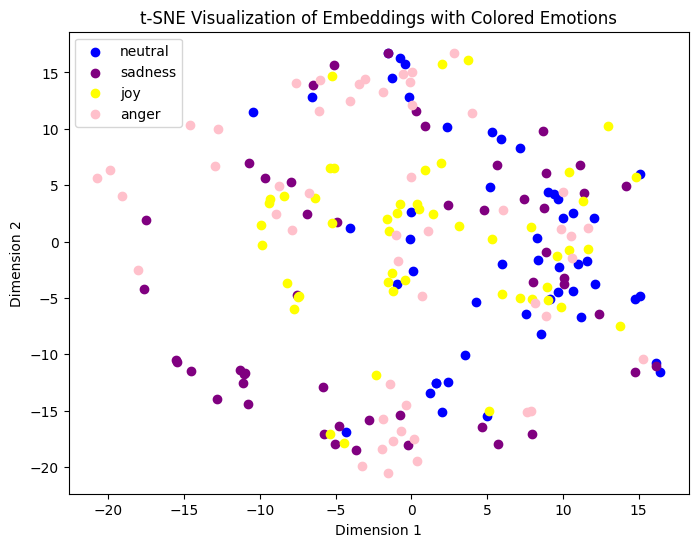

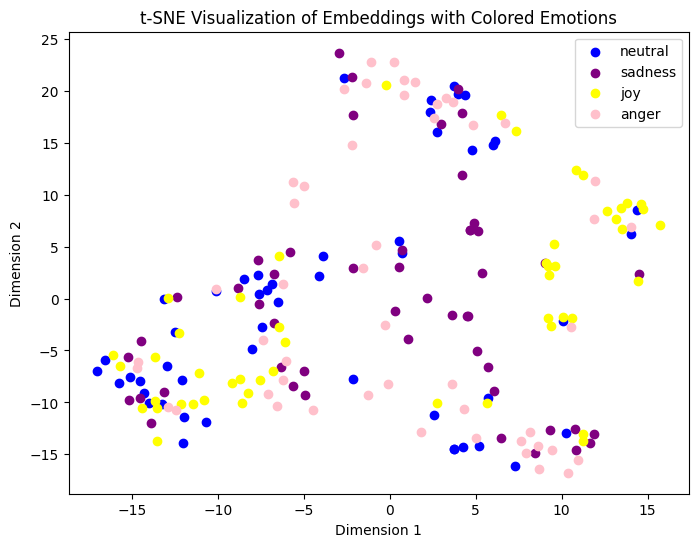

In [13]:
def plot_pca(embeddings, labels):
    # Example data: Replace with your actual data
    embeddings = embeddings.cpu().numpy()  

    # Perform dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Define a dictionary to map emotions to colors
    emotion_to_color = {
        'neutral': 'blue',
        #'surprise': 'green',
        #'fear': 'red',
        'sadness': 'purple',
        'joy': 'yellow',
        #'disgust': 'orange',
        'anger': 'pink'
    }  # Define your own color mapping

    # Map emotions to colors
    colors = [emotion_to_color[emotion] for emotion in emotion_to_color.keys()]

    # Create a scatter plot with points colored by labels
    plt.figure(figsize=(8, 6))
    for emotion, color in emotion_to_color.items():
        mask = labels == emotion
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=color, label=emotion)

    plt.title("t-SNE Visualization of Embeddings with Colored Emotions")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()

plot_pca(aligned_embeds, labels)
plot_pca(go_emo_embeds, labels)

In [14]:
from transformers import BertTokenizer, BertModel
import torch

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.to(device)

def chunk_data(data, chunk_size):
    # This function divides the data into chunks of size chunk_size
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

chunk_size = 32  # Or whatever size fits in your memory
bert_uncased_embeddings = []
data_chunks = list(chunk_data(data, chunk_size))

for data_chunk in data_chunks:
    tokens = tokenizer.batch_encode_plus(
        data_chunk,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=512  # or whatever max length you desire
    )
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    all_embeddings = outputs.last_hidden_state[:, 0, :]
    bert_uncased_embeddings.append(all_embeddings)

# Optionally, concatenate all embeddings into a single tensor
bert_uncased_embeddings = torch.cat(bert_uncased_embeddings, dim=0)

In [15]:
len(data)

350

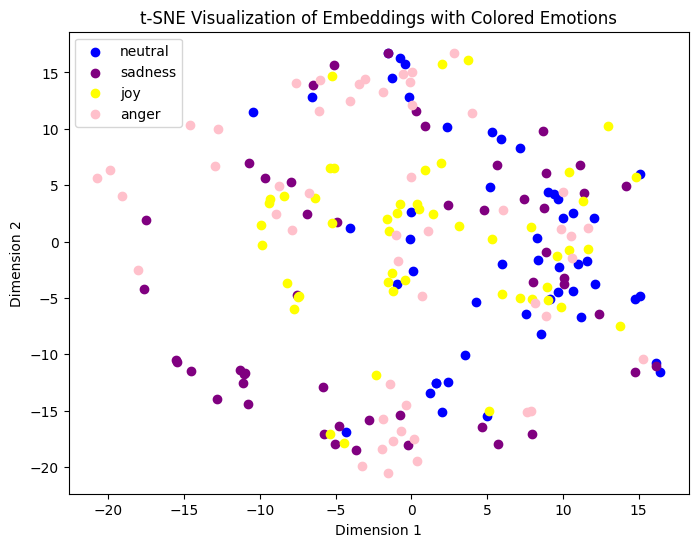

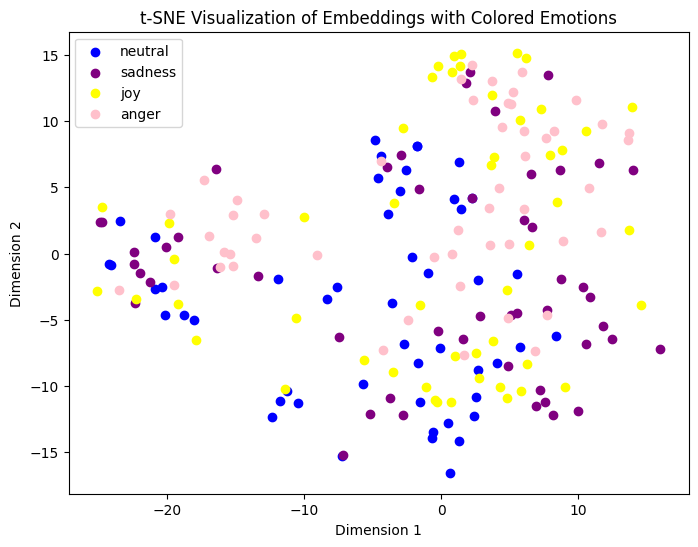

In [15]:

plot_pca(aligned_embeds, labels)
plot_pca(bert_uncased_embeddings, labels)
